# Финальное задание

Маркетинговые агенства хотят проводить успешные рекламные кампании, но рынок сложен, что требует оценивать эффективности разных вариантов, что обуславливает необходимость проведения АБ-тестирования.

### Компании заинтересованы в ответах на два вопроса:

##### 1) Будет ли кампания успешной?

##### 2) Если кампания была успешной, насколько этот успех можно объяснить рекламой?

Чтобы ответить на второй вопрос, мы обычно проводим A/B тестирование.

Большинство людей будут видеть рекламу (**экспериментальная группа**). А небольшая часть людей (**контрольная группа**) вместо этого увидит объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.

Идея задания состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на рекламе и является ли разница между группами статистически значимой.

In [216]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare, proportion_confint
from scipy.stats import shapiro,ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

Словарь данных:

 - user id: Идентификатор пользователя (уникальный).
 - test group: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.
 - converted: Если человек купил продукт, то True, иначе False.
 - total ads: Количество рекламы, увиденной человеком.
 - most ads day: День, в который человек увидел наибольшее количество рекламы.
 - most ads hour: Час дня, в который человек увидел наибольшее количество рекламы.

In [217]:
# Загрузка данных
df = pd.read_csv('/Users/Екатерина/Desktop/marketing_AB.csv', index_col=[0])
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


### I этап: анализ структуры данных и предобработка

1) Исследуйте структуру данных;
2) Преобразуйте столбцы к необходимым типам данных.
3) Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
4) Проверьте, есть ли пользователи, которые в процессе A/Bтеста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [218]:
# Информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


Здесь мы видим общее количество столбцов (6) и количество строк (588101). При этом уже исходя из такой сводной информации видно, что пропусков нет, а все столбцы имеют тип данных, соответствующий их значениям. 

Для более удобных расчетов по показателю конверсии переведем этот столбец в числовой тип данных из булевого (True - 1, False - 0):

In [219]:
df["converted"] = df["converted"].map({
    True: 1, False: 0
    })

In [220]:
# Цикл для проверки пропущенных данных, вывода уникальных значений и типа данных в столбце 
for col in df.columns:
    print(f"В столбце {col} всего {df[col].nunique()} уникальных значений:")
    print(df[col].unique()[0:7])
    print(f'Тип данных в столбце: {df[col].dtype}')
    if df[col].isna().sum() > 0:
        print(
            f"Пропуски в столбце {col} будут удалены: {df[col].isna().sum()}")
        df = df.dropna(subset=[col])
    else:
        print(f"Пропусков по столбцу {col} нет")
    print()

В столбце user id всего 588101 уникальных значений:
[1069124 1119715 1144181 1435133 1015700 1137664 1116205]
Тип данных в столбце: int64
Пропусков по столбцу user id нет

В столбце test group всего 2 уникальных значений:
['ad' 'psa']
Тип данных в столбце: object
Пропусков по столбцу test group нет

В столбце converted всего 2 уникальных значений:
[0 1]
Тип данных в столбце: int64
Пропусков по столбцу converted нет

В столбце total ads всего 807 уникальных значений:
[130  93  21 355 276 734 264]
Тип данных в столбце: int64
Пропусков по столбцу total ads нет

В столбце most ads day всего 7 уникальных значений:
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
Тип данных в столбце: object
Пропусков по столбцу most ads day нет

В столбце most ads hour всего 24 уникальных значений:
[20 22 18 10 14 13 19]
Тип данных в столбце: int64
Пропусков по столбцу most ads hour нет



In [221]:
# Проверяем, есть у нас вообще повторы id пользователей в датасете
if len(df) == df['user id'].nunique():
    print('Все значения в столбце "user id" являются уникальными')
else:
    print('Есть дупликаты пользователей')

Все значения в столбце "user id" являются уникальными


Таким образом, данный датасет не содержит дубликатов и пропусков, типы данных в столбцах соответсвуют их значениям. Дополнительная предобработка не требуется. 

### II этап: первичный анализ результатов A/B-тестирования
Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

 - количество посещений сайта;
 - суммарное количество совершённых покупок;
 - Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?

В каждой из групп рассчитайте ключевые показатели:

 - конверсия;
 - среднее количество рекламы, увиденной пользователем.
 - Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего количества увиденной рекламы в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [222]:
# Промежуточные показатели по группам: кол-во посещений сайта и суммарное кол-во совершенных покупок
df_groupped = df.groupby('test group').agg({'user id': 'count', 'converted': 'sum'}).rename(
    columns={'user id': 'visits', 'converted': 'total_conversions'}).reset_index()
display(df_groupped)

# Делаем вывод о сбалансированности выборок
print("\nПромежуточные выводы:")
if df_groupped['visits'].iloc[0] == df_groupped['visits'].iloc[1]:
    print("Количество посещений в обеих группах сопоставимо. Выборки сбалансированы.")
else:
    print("Количество посещений в группах не сопоставимо. Выборки не сбалансированы.")

,test group,visits,total_conversions
0,ad,564577,14423
1,psa,23524,420



Промежуточные выводы:
Количество посещений в группах не сопоставимо. Выборки не сбалансированы.


In [223]:
# Расчет конверсии по группам
df_groupped['conversion'] = (df_groupped['total_conversions'] / df_groupped['visits']) * 100
display(df_groupped.head())

,test group,visits,total_conversions,conversion
0,ad,564577,14423,2.554656
1,psa,23524,420,1.785411


In [224]:
# Расчет среднего количества рекламы, увиденной пользователем по группам
average_ad = df.groupby('test group')['total ads'].mean().reset_index(name='average_ad')
df_groupped = df_groupped.merge(average_ad, on='test group')
display(df_groupped)

,test group,visits,total_conversions,conversion,average_ad
0,ad,564577,14423,2.554656,24.823365
1,psa,23524,420,1.785411,24.761138


In [225]:
# Первичные выводы
print("\nПервичные выводы:")
for index, row in df_groupped.iterrows():
    print(
        f"Группа '{row['test group']}': Конверсия = {round(row['conversion'],2)}, Среднее количество рекламы = {round(row['average_ad'])}")

if df_groupped.loc[df_groupped['test group'] == 'ad', 'conversion'].values[0] > df_groupped.loc[df_groupped['test group'] == 'psa', 'conversion'].values[0]:
    print("Экспериментальная группа (ad) показывает лучшую конверсию.")
else:
    print("Группа контроля (psa) показывает лучшую конверсию.")

if round(df_groupped.loc[df_groupped['test group'] == 'ad', 'average_ad'].values[0]) > round(df_groupped.loc[df_groupped['test group'] == 'psa', 'average_ad'].values[0]):
    print("Экспериментальная группа (ad) показывает большее среднее количество рекламы.")
elif round(df_groupped.loc[df_groupped['test group'] == 'ad', 'average_ad'].values[0]) == round(df_groupped.loc[df_groupped['test group'] == 'psa', 'average_ad'].values[0]):
    print("В обеих группах среднее количество показанной рекламы одинаково.")
else:
    print("Группа контроля (psa) показывает большее среднее количество рекламы.")


Первичные выводы:
Группа 'ad': Конверсия = 2.55, Среднее количество рекламы = 25
Группа 'psa': Конверсия = 1.79, Среднее количество рекламы = 25
Экспериментальная группа (ad) показывает лучшую конверсию.
В обеих группах среднее количество показанной рекламы одинаково.


Таким образом, конверсия выше в первой группе, где показывали рекламу, однако, среднее количество показанной рекламы одинаково между группами. В связи с этим можем сделать предварительный вывод, что при одинаковом показе рекламы и объявления о госслужбе, именно реклама способствует большей конверсии. 

### III этап: статистический анализ результатов A/B-тестирования
Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.

Не забудьте проверить данные на нормальность там, где это необходимо.

С помощью аппарата статистических тестов определите:
 - Есть ли статистическая разница между конверсиями в группах А и B?
 - Есть ли статистическая разница между средними количествами увиденной рекламы в группах А и B?
 - Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:
    - конверсий в каждой из групп;
    - разницы конверсий в группах;
    - среднего количества увиденной рекламы в группах А и B.
 - Проинтерпретируйте построенные доверительные интервалы для конверсий и среднего количества увиденной рекламы группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

In [226]:
# Разделяем данные по выборкам
ad = df[df['test group'] == 'ad']
psa = df[df['test group'] == 'psa']

In [227]:
# Задаем уровень значимости для всех статистических тестов
alpha = 0.05

In [228]:
# Проверяем данные на нормальность распределения (Shapiro-Wilk тест)

def shapiro_function(df,col,alpha=0.05):
    
    # Формулируем гипотезы
    H0 = 'Данные в группе имеют нормальное распределение'
    H1 = 'Данные в группе имеют не нормальное распределение'
    
    # Shapiro-Wilk тест
    test_normality = stats.shapiro(df[col])

    print("Проверка на нормальность:")
    if test_normality.pvalue < alpha:
        print(f'Отклоняем нулевую гипотезу, принимаем альтернативную:')
        print(H1)
        print(round(test_normality.pvalue,5))
    else:
        print(f'Мы не можем отклонить нулевую гипотезу и принимаем ее:')
        print(H0)
        print(round(test_normality.pvalue,5))


##### Проверяем различия по конверсиям между группами:

(так как мы выше предположили, что в группе с рекламой конверия выше, то это и будем проверять с помощью статистических тестов)

In [229]:
# Гипотезы:
H0 = "В экспериментальнй группе (с рекламой) конверсия не выше, чем в контрольной группе"
H1 = "В экспериментальнй группе (с рекламой) конверсия выше"

In [230]:
# У нас уже есть датасет с рассчитанным количеством посещений visits сайта 
# и количетсвом случаев "успешной" конверсии total_conversions
df_groupped.head()

,test group,visits,total_conversions,conversion,average_ad
0,ad,564577,14423,2.554656,24.823365
1,psa,23524,420,1.785411,24.761138


Для сравнения пропорций конверсии мы выбираем Z-критерий для пропорций, так как выборка у нас большая, что будет достаточно для использования этого теста.

In [254]:
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=df_groupped['total_conversions'], #число «успехов»
    nobs=df_groupped['visits'], #общее число наблюдений
    alternative='larger'
)

print('p-value: ', p_value)

if (p_value <= alpha):
    print("Мы отвергаем нулевую гипотезу, верна альтернативная: ")
    print(H1)
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")
    print(H0)

p-value:  8.526403580779863e-14
Мы отвергаем нулевую гипотезу, верна альтернативная: 
В экспериментальнй группе (с рекламой) конверсия выше


Таким образом, конверсия в экспериментальной группе с показом рекламы статистически значимо выше конверсии в группе контроля. 

95 % доверительные интервалы для конверсий:

In [232]:
# Функция для расчета доверительного интервала для пропорции
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps 
    return lower_bound, upper_bound

Доверительный интервал для конверсии в экспериментальной группе: (np.float64(2.51), np.float64(2.6))
Доверительный интервал для конверсии в контрольной группе: (np.float64(1.62), np.float64(1.95))


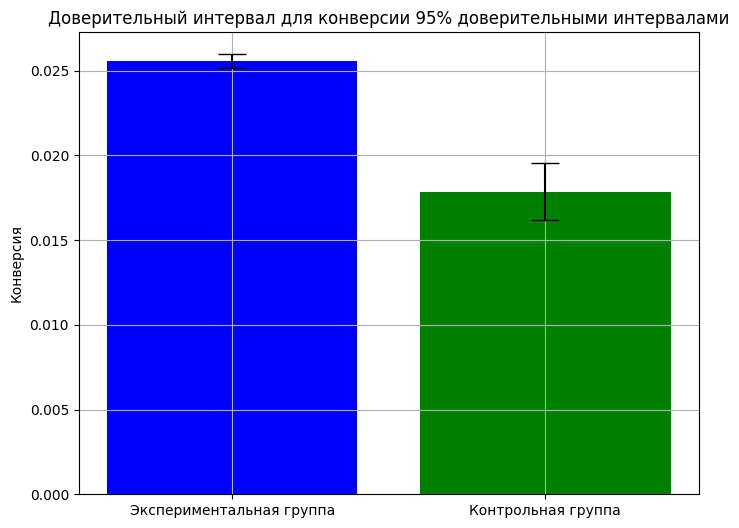

In [233]:
# доверительный интервал для конверсии в экспериментальной группе
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=ad['converted'].mean(),
    n=ad['user id'].count() 
)

# доверительный интервал для конверсии в контрольной группе
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=psa['converted'].mean(), 
    n=psa['user id'].count()
)

print('Доверительный интервал для конверсии в экспериментальной группе: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в контрольной группе: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

# Визуализация данных
groups = ['Экспериментальная группа', 'Контрольная группа']
means = [ad['converted'].mean(), psa['converted'].mean()]
ci_lowers = [lower_bound_a, lower_bound_b]
ci_uppers = [upper_bound_a, upper_bound_b]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(groups, means, yerr=[np.subtract(means, ci_lowers), np.subtract(ci_uppers, means)], capsize=10, color=['blue', 'green'])
ax.set_ylabel('Конверсия')
ax.set_title('Доверительный интервал для конверсии 95% доверительными интервалами')
ax.grid(True)

plt.show()

Вывод: доверительные интервалы не пересекаются, то есть значимая разница между конверсиями в двух группах есть. 

95 % доверительные интервалы для разницы конверсий в группах:

In [234]:
# Функция для расчета доверительного интервала для разницы пропорций
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma
    diff = x_p[1] - x_p[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return lower_bound, upper_bound

In [ ]:
# размеры выборок 
n = [ad['user id'].count(), psa['user id'].count()]
# выборочная пропорция групп 
x_p = [ad['converted'].mean(), psa['converted'].mean()]

# доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Доверительный интервал для разности пропорций конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (np.float64(-0.94), np.float64(-0.6))


Вывод: интервал полностью находится ниже нуля (полностью отрицательный), то есть с 95% надежнстью можно сказать о том, что второй вариант (контрольная группа) значимо уступает по метрике конверсии первой группе (экспериментальной)

##### Проверяем различия по среднему количеству увиденной рекламы между группами:

(так как мы выше в первичных выводах предположили, что оно не отличается между группами то это и возьмем за основу для формирования гипотез)

In [130]:
# Гипотезы:
H0 = "Среднее количество увиденной рекламы не отличается в экспериментальной и контрольной группах"
H1 = "Среднее количество увиденной рекламы отличается в экспериментальной и контрольной группах"

In [131]:
# Shapiro-Wilk тест
shapiro_function(ad,'total ads')
shapiro_function(psa,'total ads')

Проверка на нормальность:
Отклоняем нулевую гипотезу, принимаем альтернативную:
Данные в группе имеют не нормальное распределение
0.0
Проверка на нормальность:
Отклоняем нулевую гипотезу, принимаем альтернативную:
Данные в группе имеют не нормальное распределение
0.0


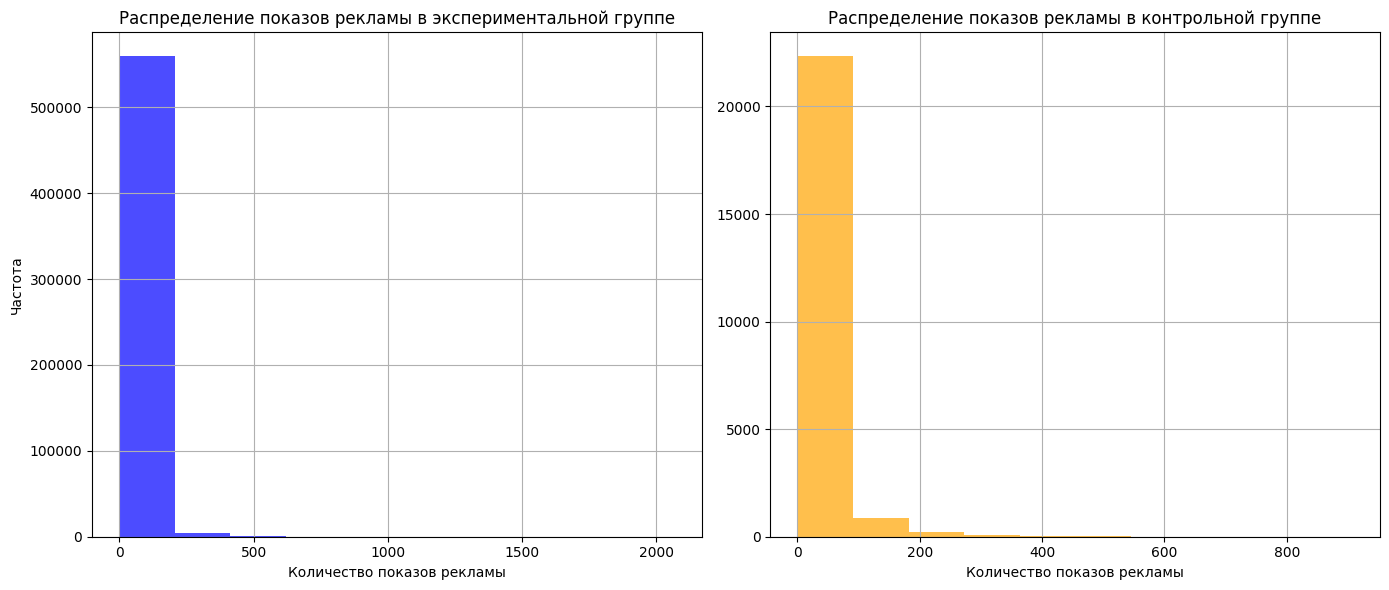

In [132]:
# Создание подграфиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для группы A (ad)
ax1.hist(ad['total ads'], bins=10, alpha=0.7, color='blue')
ax1.set_title('Распределение показов рекламы в экспериментальной группе')
ax1.set_xlabel('Количество показов рекламы')
ax1.set_ylabel('Частота')
ax1.grid(True)

# Гистограмма для группы B (psa)
ax2.hist(psa['total ads'], bins=10, alpha=0.7, color='orange')
ax2.set_title('Распределение показов рекламы в контрольной группе')
ax2.set_xlabel('Количество показов рекламы')
ax2.grid(True)

plt.tight_layout()
plt.show()

Не нормальность распределения в обеих группах также подтверждается графиками распределения.

Следовательно, нам нужен непараметрически критерий для выявления статистической разницы между группами. Например, тест Манна-Уитни

In [253]:
# вычисляем результат теста Манна — Уитни для выборок
__, p_value = mannwhitneyu(
    x=ad['total ads'],
    y=psa['total ads'],
    alternative='two-sided'
)
print('p-value: ', p_value)

if (p_value <= alpha):
    print("Мы отвергаем нулевую гипотезу, верна альтернативная: ")
    print(H1)
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")
    print(H0)

p-value:  4.6909108547205694e-11
Мы отвергаем нулевую гипотезу, верна альтернативная: 
В экспериментальнй группе (с рекламой) конверсия выше


Соответственно, количество увиденной рекламы в группах отличается. 

95 % доверительные интервалы для среднего количества увиденной рекламы в группах:

Так как у нас выборка достаточно большая (более 500 тысяч человек в одной и более 20 тысяч в другой), то будем рассчитывать по формулам для истинных значений с расчетом z-критерия, так как в такой большой выборке показатели будут максимально близки к истинным.

In [239]:
# Функция для расчета доверительного интервала среднего количества увиденной рекламы
def z_mean_conf_interval(x_mean, sigma, n, gamma=0.95):  
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * sigma/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return lower_bound, upper_bound

# Расчет стандартного отклонения и среднего значения для экспериментальной группы
sigma_ad = ad['total ads'].std()
x_mean_ad = ad['total ads'].mean()
n_ad = ad['total ads'].count()
lower_bound1, upper_bound1 = z_mean_conf_interval(x_mean_ad, sigma_ad, n_ad)

# Расчет стандартного отклонения и среднего значения для контрольной группы
sigma_psa = psa['total ads'].std()
x_mean_psa = psa['total ads'].mean()
n_psa = psa['total ads'].count()
lower_bound2, upper_bound2 = z_mean_conf_interval(x_mean_psa, sigma_psa, n_psa)


print('Доверительный интервал среднего количества увиденной рекламы в экспериментальной группе: {}'.format((round(lower_bound1,3), round(upper_bound1,3))))
print('Доверительный интервал среднего количества увиденной рекламы в экспериментальной группе: {}'.format((round(lower_bound2,3), round(upper_bound2,3))))

Доверительный интервал среднего количества увиденной рекламы в экспериментальной группе: (np.float64(24.709), np.float64(24.937))
Доверительный интервал среднего количества увиденной рекламы в экспериментальной группе: (np.float64(24.213), np.float64(25.309))


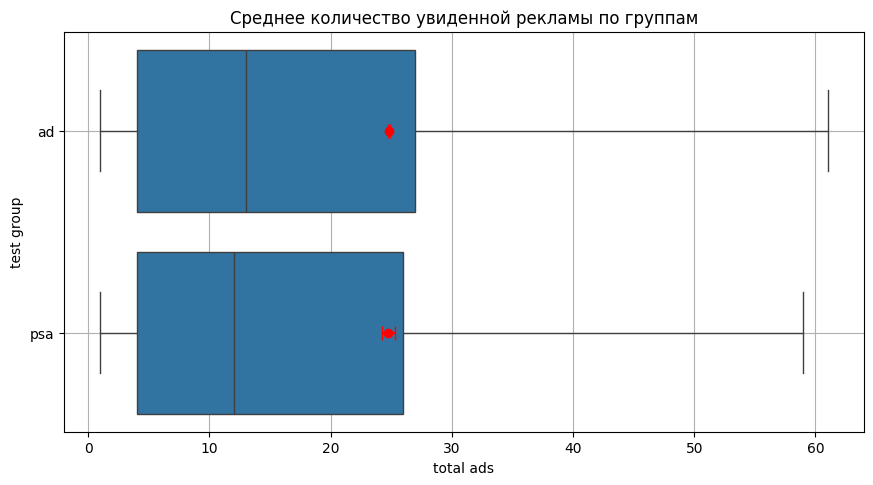

In [240]:
# Боксплоты распределений количества увиденной рекламы по группам
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.boxplot(data=df, x='total ads', y='test group', ax=ax, showfliers=False)
ax.set_title('Среднее количество увиденной рекламы по группам')
ax.grid(True)

# Добавление доверительных интервалов на график
positions = [0, 1]
means = [x_mean_ad, x_mean_psa]
ci_lower_bounds = [lower_bound1, lower_bound2]
ci_upper_bounds = [upper_bound1, upper_bound2]

for pos, mean, lower, upper in zip(positions, means, ci_lower_bounds, ci_upper_bounds):
    ax.errorbar(x=mean, y=pos, xerr=[[mean - lower], [upper - mean]], fmt='o', color='red', capsize=5)

plt.show()

Вывод: доверительные интервалы пересекаются и вообще практически совпадают, соответственно, среднее количество увиденной рекламы не различается достоверно между группами

Таким образом, можно сделать вывод, что показы рекламы в экспериментальной группе и объявляений о военной службе в контрольной группе значимо не различалось: хоть мы и получили значимое различие по результатам теста Манна-Уитни, но доверительные интервалы говорят об отсутствии значимых различий между средним количесвом показов между группами. Поэтому будем считать, что воздействие фактора было одинаково в двух группах.При этом конверсия оказалась значимо выше именно в экспериментальной группе с показом рекламы, что подтвердилось как по результатам Z-теста пропорций (p-value < 0,00001) и по результатам расчетов 95% доверительных интервалов пропорций конверсиф и разницы пропорцйи конверсий. Соответсвенно, можем сказать, что рекламная компания была успешной и мы можем сказать, что именно этот вариант принесет больше прибыли компании.